
# <center><u>**`Ensemble ML Algorithms - Boosting`**</u></center>











In [ ]:
pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np 
import pandas as pd 
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance
import gc # for deleting unused variables
%matplotlib inline

import os
import warnings
warnings.filterwarnings('ignore')

In [ ]:
dtypes = {
        'ip'            : 'uint16',
        'app'           : 'uint16',
        'device'        : 'uint16',
        'os'            : 'uint16',
        'channel'       : 'uint16',
        'is_attributed' : 'uint8',
        'click_id'      : 'uint32' 
        }


testing = True
if testing:
    train_path = "train_sample.csv"
    skiprows = None
    nrows = None
    colnames=['ip','app','device','os', 'channel', 'click_time', 'is_attributed']
else:
    train_path = "train.csv"
    skiprows = range(1, 144903891)
    nrows = 10000000
    colnames=['ip','app','device','os', 'channel', 'click_time', 'is_attributed']

train_sample =  pd.read_csv(train_path, skiprows=skiprows, nrows=nrows, dtype=dtypes, usecols=colnames)

In [ ]:
len(train_sample.index)

100000

In [ ]:
print(train_sample.memory_usage())

Index               128
ip               200000
app              200000
device           200000
os               200000
channel          200000
click_time       800000
is_attributed    100000
dtype: int64


In [ ]:
print('Training dataset uses {0} MB'.format(train_sample.memory_usage().sum()/1024**2))

Training dataset uses 1.812103271484375 MB


In [ ]:
train_sample.head()

,ip,app,device,os,channel,click_time,is_attributed
0,22004,12,1,13,497,2017-11-07 09:30:38,0
1,40024,25,1,17,259,2017-11-07 13:40:27,0
2,35888,12,1,19,212,2017-11-07 18:05:24,0
3,29048,13,1,13,477,2017-11-07 04:58:08,0
4,2877,12,1,1,178,2017-11-09 09:00:09,0


In [ ]:
train_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   ip             100000 non-null  uint16
 1   app            100000 non-null  uint16
 2   device         100000 non-null  uint16
 3   os             100000 non-null  uint16
 4   channel        100000 non-null  uint16
 5   click_time     100000 non-null  object
 6   is_attributed  100000 non-null  uint8 
dtypes: object(1), uint16(5), uint8(1)
memory usage: 1.8+ MB


In [ ]:
def fraction_unique(x):
    return len(train_sample[x].unique())

number_unique_vals = {x: fraction_unique(x) for x in train_sample.columns}

{'app': 161,
 'channel': 161,
 'click_time': 80350,
 'device': 100,
 'ip': 28470,
 'is_attributed': 2,
 'os': 130}

In [ ]:
def fraction_unique(x):
    return len(train_sample[x].unique())
number_unique_vals = {x: fraction_unique(x) for x in train_sample.columns}
number_unique_vals

{'ip': 28470,
 'app': 161,
 'device': 100,
 'os': 130,
 'channel': 161,
 'click_time': 80350,
 'is_attributed': 2}

In [ ]:
train_sample.dtypes

ip               uint16
app              uint16
device           uint16
os               uint16
channel          uint16
click_time       object
is_attributed     uint8
dtype: object

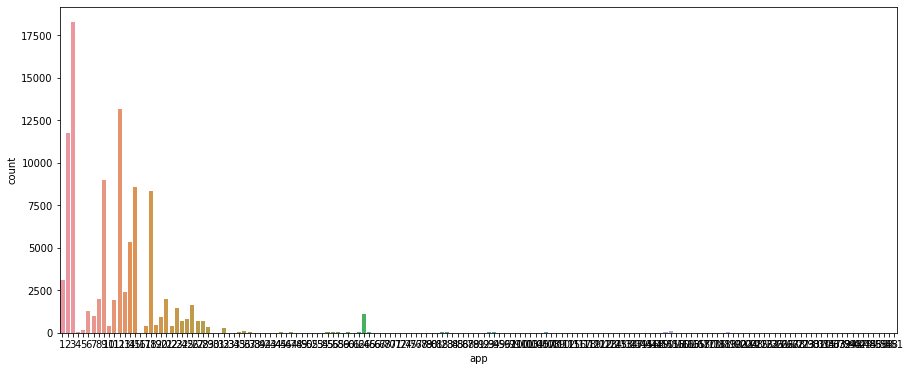

In [ ]:
plt.figure(figsize=(15, 6))
sns.countplot(x='app', data=train_sample)
plt.show()

some 'apps' have a disproportionately high number of clicks (>15k), and some are very rare (3-4)


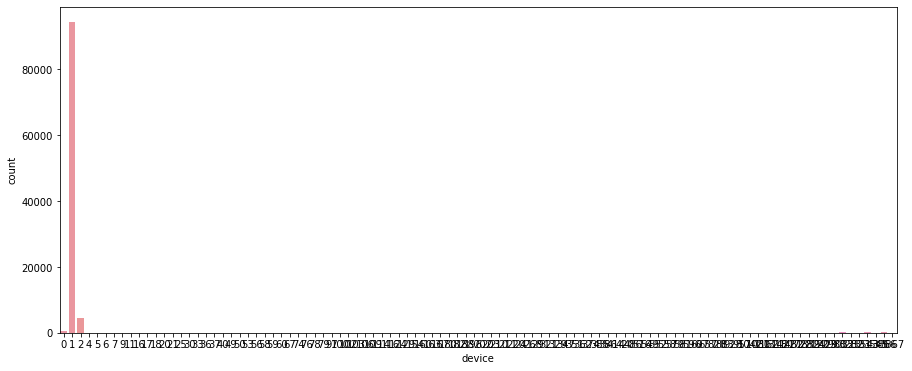

In [ ]:
plt.figure(figsize=(15, 6))
sns.countplot(x='device',data=train_sample)
plt.show()

The above result is expected because a few popular devices are used heavily


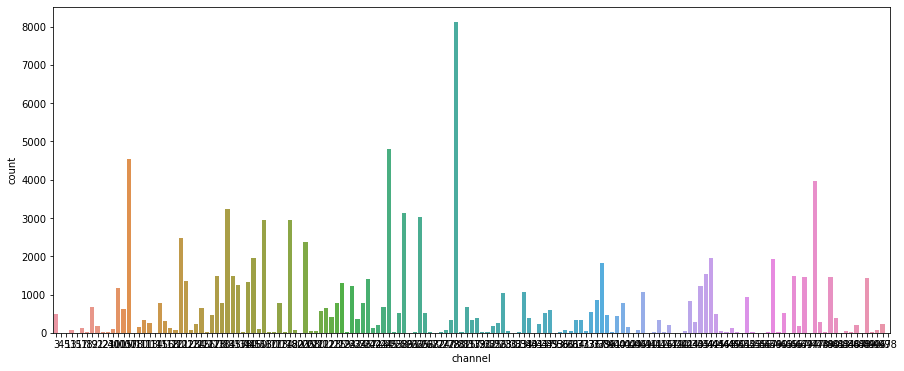

In [ ]:
plt.figure(figsize=(15, 6))
sns.countplot(x='channel',data=train_sample)
plt.show()

you can see abobe that various channels get clicks in comparable quantities


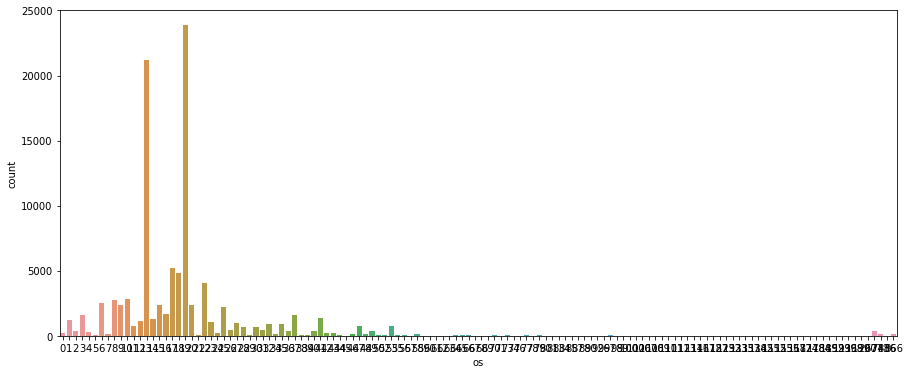

In [ ]:
plt.figure(figsize=(15, 6))
sns.countplot(x='os',data=train_sample)
plt.show()

there are a couple commos OSes (android and ios?), though some are rare and can indicate suspicion 


In [ ]:
# target variable distribution
100 * (train_sample['is_attributed'].astype('object').value_counts()/len(train_sample.index))

0    99.773
1     0.227
Name: is_attributed, dtype: float64

Only **about 0.2% of clicks are 'fraudulent'**, which is expected in a fraud detection problem. Such high class imbalance is probably going to be the toughest challenge of this problem.

In [ ]:
app_target = train_sample.groupby('app').is_attributed.agg(['mean','count'])
app_target

,mean,count
app,,
1,0.000000,3135
2,0.000000,11737
3,0.000219,18279
4,0.000000,58
5,0.074468,188
...,...,...
486,0.000000,1
536,0.000000,1
538,0.000000,1


In [ ]:
frequent_apps = train_sample.groupby('app').size().reset_index(name='count')
frequent_apps = frequent_apps [frequent_apps ['count'] >frequent_apps['count'].quantile (0.80)]
frequent_apps = frequent_apps.merge(train_sample, on='app', how ='inner')
frequent_apps.head()

,app,count,ip,device,os,channel,click_time,is_attributed
0,1,3135,17059,1,17,135,2017-11-09 01:17:58,0
1,1,3135,52432,1,13,115,2017-11-07 17:22:52,0
2,1,3135,23706,1,27,124,2017-11-07 09:37:21,0
3,1,3135,58458,1,19,101,2017-11-09 14:27:57,0
4,1,3135,34067,1,15,134,2017-11-07 15:06:06,0


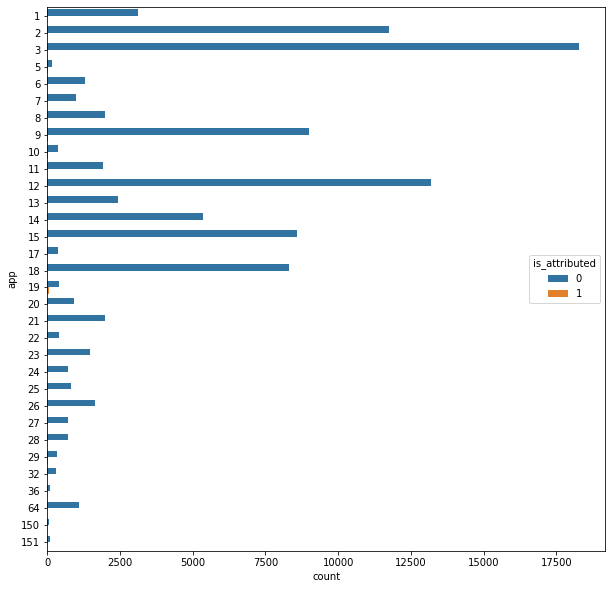

In [ ]:
plt.figure(figsize=(10,10))
sns.countplot(y="app", hue='is_attributed',data=frequent_apps)
plt.show()

In [ ]:
def timeFeatures(df):
    df['datetime'] = pd.to_datetime(df['click_time'])
    df['day_of_week'] = df['datetime'].dt.dayofweek
    df["day_of_year"] = df['datetime'].dt.dayofyear
    df["month"] = df['datetime'].dt.month
    df["hour"] = df['datetime'].dt.hour

    return df
    

In [ ]:
train_sample = timeFeatures(train_sample)
train_sample.drop(['click_time','datetime'], axis=1, inplace=True)
train_sample.head()

,ip,app,device,os,channel,is_attributed,day_of_week,day_of_year,month,hour
0,22004,12,1,13,497,0,1,311,11,9
1,40024,25,1,17,259,0,1,311,11,13
2,35888,12,1,19,212,0,1,311,11,18
3,29048,13,1,13,477,0,1,311,11,4
4,2877,12,1,1,178,0,3,313,11,9


In [ ]:
train_sample.dtypes

ip               uint16
app              uint16
device           uint16
os               uint16
channel          uint16
is_attributed     uint8
day_of_week       int64
day_of_year       int64
month             int64
hour              int64
dtype: object

In [ ]:
print('Training dataset uses {0} MB'.format(train_sample.memory_usage().sum()/1024**2))

Training dataset uses 4.100921630859375 MB


In [ ]:
int_vars = ['app','device',	'os',	'channel','day_of_week','day_of_year','month','hour']
train_sample[int_vars] = train_sample[int_vars].astype('uint16')

In [ ]:
train_sample.dtypes

ip               uint16
app              uint16
device           uint16
os               uint16
channel          uint16
is_attributed     uint8
day_of_week      uint16
day_of_year      uint16
month            uint16
hour             uint16
dtype: object

In [ ]:
print('Training dataset uses {0} MB'.format(train_sample.memory_usage().sum()/1024**2))

Training dataset uses 1.812103271484375 MB


In [ ]:
ip_count = train_sample.groupby('ip').size().reset_index(name='ip_count').astype('int16')
ip_count.head()

,ip,ip_count
0,8,1
1,9,1
2,10,3
3,14,1
4,16,6


In [ ]:
def grouped_features(df)
    ip_count = df.groupby('ip').size().reset_index(name='ip_count').astype('uint16')
    
    ip_day_hour = df.groupby(['ip','day_of_week', 'hour']).size().reset_index(name='ip_day_hour').astype('uint16')
    
    ip_hour_channel = df[['ip','hour', 'channel']].groupby(['ip','hour', 'channel']).size().reset_index(name='ip_day_channel').astype('uint16')
    
    ip_hour_os = df.groupby(['ip','hour', 'os']).channel.count().reset_index(name='ip_day_os').astype('uint16')
    
    ip_hour_app = df.groupby(['ip','hour', 'app']).channel.count().reset_index(name='ip_day_app').astype('uint16')
    
    ip_hour_device = df.groupby(['ip','hour', 'device']).channel.count().reset_index(name='ip_day_device').astype('uint16')

    df = pd.merge(df,ip_count, on='ip', how='left')
    
    del ip_count


    df = pd.merge(df, ip_day_hour, on=['ip','day_of_week', 'hour'], how='left')
    
    del ip_day_hour

    df =pd.merge(df, ip_hour_channel, on=['ip','hour', 'channel'], how='left')
    
    del ip_hour_channel

    df =pd.merge(df, ip_hour_os, on=['ip','hour', 'os'], how='left')
    
    del ip_hour_os

    df = pd.merge(df, ip_hour_app, on=['ip','hour', 'app'], how='left')
    
    del ip_hour_app 

    df =  pd.merge(df, ip_hour_device, on=['ip','hour', 'device'], how='left')
    
    del ip_hour_device
    
    return df
    
    

In [ ]:
train_sample = grouped_features(train_sample)

In [ ]:
train_sample.head()

,ip,app,device,os,channel,is_attributed,day_of_week,day_of_year,month,hour,ip_count,ip_day_hour,ip_day_channel,ip_day_os,ip_day_app,ip_day_device
0,22004,12,1,13,497,0,1,311,11,9,8,1,1,1,1,1
1,40024,25,1,17,259,0,1,311,11,13,149,4,1,1,1,8
2,35888,12,1,19,212,0,1,311,11,18,2,1,1,1,1,1
3,29048,13,1,13,477,0,1,311,11,4,3,1,1,1,1,1
4,2877,12,1,1,178,0,3,313,11,9,4,1,1,1,1,1


In [ ]:
print('Training dataset uses {0} MB'.format(train_sample.memory_usage().sum()/1024**2))

Training dataset uses 3.719329833984375 MB


In [ ]:
X = train_sample.drop('is_attributed', axis=1)
y = train_sample[['is_attributed']]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=101)

print(f"Train Data: {X_train.shape},{y_train.shape}")
print(f"Test Data: {X_test.shape},{y_test.shape}")

Train Data: (80000, 15),(80000, 1)
Test Data: (20000, 15),(20000, 1)


In [ ]:
print(y_train.mean())
print(y_test.mean())

is_attributed    0.002275
dtype: float64
is_attributed    0.00225
dtype: float64


In [ ]:
tree = DecisionTreeClassifier(max_depth=2, random_state=1)


adaboost_model_1 = AdaBoostClassifier(
    base_estimator=tree,
    n_estimators=600,
    learning_rate=1.5,
    algorithm='SAMME', random_state=1
)

In [ ]:
adaboost_model_1.fit(X_train,y_train)

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(max_depth=2,
                                                         random_state=1),
                   learning_rate=1.5, n_estimators=600, random_state=1)

In [ ]:
predictions =adaboost_model_1.predict_proba(X_test)
predictions[:10]

array([[0.54049582, 0.45950418],
       [0.53588662, 0.46411338],
       [0.53885559, 0.46114441],
       [0.52427816, 0.47572184],
       [0.52018053, 0.47981947],
       [0.5308397 , 0.4691603 ],
       [0.53055748, 0.46944252],
       [0.54126954, 0.45873046],
       [0.52347347, 0.47652653],
       [0.51624249, 0.48375751]])

In [ ]:
metrics.roc_auc_score(y_test,predictions[:,1])

0.9523839750549848

In [ ]:
param_grid = {"base_estimator__max_depth" : [2,5], "n_estimators" : [200, 400, 600] }

In [ ]:
tree = DecisionTreeClassifier(random_state=1)

ABC = AdaBoostClassifier(
    base_estimator=tree,
    learning_rate=0.6,
    algorithm="SAMME" 
) 

#### Run grid search CV


In [ ]:
folds = 3
grid_search_ABC = GridSearchCV(
    ABC, 
    cv=folds, 
    param_grid=param_grid,
    scoring = 'roc_auc',
    return_train_score= True,
    verbose=1
)

In [ ]:
grid_search_ABC.fit(X_train,y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


GridSearchCV(cv=3,
             estimator=AdaBoostClassifier(algorithm='SAMME',
                                          base_estimator=DecisionTreeClassifier(random_state=1),
                                          learning_rate=0.6),
             param_grid={'base_estimator__max_depth': [2, 5],
                         'n_estimators': [200, 400, 600]},
             return_train_score=True, scoring='roc_auc', verbose=1)

In [ ]:
cv_results = pd.DataFrame(grid_search_ABC. cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_base_estimator__max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,12.272090,1.252689,0.230918,0.073013,2,200,"{'base_estimator__max_depth': 2, 'n_estimators...",0.926966,0.975725,0.955801,0.952831,0.020017,1,0.996306,0.995094,0.996461,0.995954,6.111043e-04
1,22.391330,2.098350,0.322592,0.005795,2,400,"{'base_estimator__max_depth': 2, 'n_estimators...",0.920643,0.974585,0.956496,0.950575,0.022416,2,0.997991,0.996683,0.997996,0.997556,6.179779e-04
2,32.760273,1.746936,0.611979,0.093094,2,600,"{'base_estimator__max_depth': 2, 'n_estimators...",0.921720,0.973335,0.953955,0.949670,0.021288,3,0.998494,0.997923,0.998417,0.998278,2.530744e-04
3,26.897139,2.892222,0.327676,0.028990,5,200,"{'base_estimator__max_depth': 5, 'n_estimators...",0.902378,0.940082,0.941979,0.928146,0.018237,4,1.000000,1.000000,1.000000,1.000000,0.000000e+00
4,52.920382,4.213625,0.489527,0.044436,5,400,"{'base_estimator__max_depth': 5, 'n_estimators...",0.890533,0.931315,0.935398,0.919082,0.020256,5,1.000000,1.000000,1.000000,1.000000,0.000000e+00
5,82.752111,6.873949,0.665178,0.025203,5,600,"{'base_estimator__max_depth': 5, 'n_estimators...",0.882506,0.940416,0.934161,0.919028,0.025950,6,1.000000,1.000000,1.000000,1.000000,6.409876e-17


In [ ]:
tree = DecisionTreeClassifier(max_depth=2,random_state=1)
ABC = AdaBoostClassifier(
    base_estimator=tree,
    learning_rate=0.6,
    n_estimators=200,
    algorithm="SAMME" , random_state=1)
ABC.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(max_depth=2,
                                                         random_state=1),
                   learning_rate=0.6, n_estimators=200, random_state=1)

In [ ]:
predictions = ABC.predict_proba(X_test)
predictions[:10]

array([[0.61058431, 0.38941569],
       [0.60742586, 0.39257414],
       [0.63265753, 0.36734247],
       [0.58758342, 0.41241658],
       [0.57045678, 0.42954322],
       [0.61162484, 0.38837516],
       [0.59403993, 0.40596007],
       [0.60805124, 0.39194876],
       [0.60362848, 0.39637152],
       [0.57654304, 0.42345696]])

In [ ]:
metrics.roc_auc_score(y_test, predictions[:,1])

0.960727748545338

In [ ]:
param_grid = {"learning_rate":[0.2, 0.6, 0.9],
              "subsample":[0.3, 0.6, 0.9]}

In [ ]:
GBC = GradientBoostingClassifier(max_depth=2 ,n_estimators= 200,random_state=1 )

In [ ]:
folds = 3
grid_search_GBC = GridSearchCV(GBC,
                   cv=folds,
                   param_grid=param_grid,
                   scoring='roc_auc',
                   return_train_score=True,
                   verbose=1)

grid_search_GBC.fit(X_train,y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


GridSearchCV(cv=3,
             estimator=GradientBoostingClassifier(max_depth=2, n_estimators=200,
                                                  random_state=1),
             param_grid={'learning_rate': [0.2, 0.6, 0.9],
                         'subsample': [0.3, 0.6, 0.9]},
             return_train_score=True, scoring='roc_auc', verbose=1)

In [ ]:
cv_results = pd.DataFrame(grid_search_ABC. cv_results_)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_base_estimator__max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,12.272090,1.252689,0.230918,0.073013,2,200,"{'base_estimator__max_depth': 2, 'n_estimators...",0.926966,0.975725,0.955801,0.952831,0.020017,1,0.996306,0.995094,0.996461,0.995954,0.000611
1,22.391330,2.098350,0.322592,0.005795,2,400,"{'base_estimator__max_depth': 2, 'n_estimators...",0.920643,0.974585,0.956496,0.950575,0.022416,2,0.997991,0.996683,0.997996,0.997556,0.000618
2,32.760273,1.746936,0.611979,0.093094,2,600,"{'base_estimator__max_depth': 2, 'n_estimators...",0.921720,0.973335,0.953955,0.949670,0.021288,3,0.998494,0.997923,0.998417,0.998278,0.000253
3,26.897139,2.892222,0.327676,0.028990,5,200,"{'base_estimator__max_depth': 5, 'n_estimators...",0.902378,0.940082,0.941979,0.928146,0.018237,4,1.000000,1.000000,1.000000,1.000000,0.000000
4,52.920382,4.213625,0.489527,0.044436,5,400,"{'base_estimator__max_depth': 5, 'n_estimators...",0.890533,0.931315,0.935398,0.919082,0.020256,5,1.000000,1.000000,1.000000,1.000000,0.000000


In [ ]:
GBC.fit(X_train,y_train)
predictions = GBC.predict_proba(X_test)
predictions[:10]

array([[9.99759635e-01, 2.40365249e-04],
       [9.99683461e-01, 3.16539468e-04],
       [9.99385527e-01, 6.14472923e-04],
       [9.99790280e-01, 2.09720179e-04],
       [9.99189954e-01, 8.10045513e-04],
       [9.99824758e-01, 1.75242409e-04],
       [9.99618179e-01, 3.81820940e-04],
       [9.99712348e-01, 2.87651814e-04],
       [9.99781825e-01, 2.18175325e-04],
       [9.98997601e-01, 1.00239939e-03]])

In [ ]:
metrics.roc_auc_score(y_test, predictions[:,1])

0.9599148083187171

In [ ]:
model = XGBClassifier(random_state=1)
model.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=1, ...)

In [ ]:
y_pred = model.predict_proba(X_test)
y_pred[:10]

array([[9.9999809e-01, 1.9337567e-06],
       [9.9998653e-01, 1.3449854e-05],
       [9.9997407e-01, 2.5916344e-05],
       [9.9952990e-01, 4.7011764e-04],
       [9.9978644e-01, 2.1357677e-04],
       [9.9999368e-01, 6.3347384e-06],
       [9.9991673e-01, 8.3290950e-05],
       [9.9998868e-01, 1.1305605e-05],
       [9.9981380e-01, 1.8618901e-04],
       [9.9910051e-01, 8.9947559e-04]], dtype=float32)

In [ ]:
roc = metrics.roc_auc_score(y_test, y_pred[:,1])
print("AUC: %.2F%%" % (roc *100.0))

AUC: 96.06%


In [ ]:
folds = 3
param_grid ={'learning_rate':[0.2, 0.6], 'subsample':[0.3, 0.6, 0.9]}
xgb_model = XGBClassifier(max_depth=2, n_estimators=200,random_state=1  )
model_cv = GridSearchCV(estimator=xgb_model, param_grid=param_grid,scoring='roc_auc', 
                        cv=folds, verbose=1, return_train_score=True)

In [ ]:
model_cv.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=2,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=200, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=1, ...),
             param_grid={'learning_rate': [0.2, 0.6],
                         'subsample': [0.3, 0.6, 0.9]},
             return_train_score=True, scoring='roc_auc', verbose=1)

In [ ]:
cv_results = pd.DataFrame(model_cv. cv_results_)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,2.968826,0.616229,0.035085,0.001194,0.2,0.3,"{'learning_rate': 0.2, 'subsample': 0.3}",0.918476,0.966470,0.959373,0.948106,0.021151,3,0.990313,0.984284,0.993700,0.989432,0.003894
1,3.286711,0.524699,0.034507,0.000651,0.2,0.6,"{'learning_rate': 0.2, 'subsample': 0.6}",0.933275,0.978913,0.950468,0.954218,0.018819,1,0.993116,0.987288,0.994242,0.991549,0.003047
2,3.437457,1.164109,0.034061,0.000443,0.2,0.9,"{'learning_rate': 0.2, 'subsample': 0.9}",0.924940,0.973210,0.950138,0.949429,0.019712,2,0.993739,0.989940,0.994238,0.992639,0.001919
3,2.938889,0.581674,0.037503,0.002785,0.6,0.3,"{'learning_rate': 0.6, 'subsample': 0.3}",0.903039,0.948284,0.920718,0.924014,0.018618,6,0.997775,0.995323,0.996475,0.996525,0.001002
4,3.252252,0.506229,0.034288,0.000526,0.6,0.6,"{'learning_rate': 0.6, 'subsample': 0.6}",0.909776,0.970954,0.944572,0.941768,0.025054,4,0.999613,0.998645,0.999649,0.999303,0.000465


In [ ]:
params = {'learning_rate':0.2,
          'max_depth': 2,
          'n_estimators':200,
          'sub_sample':0.6,
          'objective':'binary:logistic',
          'random_state': 1
    
}
XGB = XGBClassifier(params=params)
XGB.fit(X_train, y_train)

[08:52:19] WARNING: ../src/learner.cc:767: 
Parameters: { "params" } are not used.



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              params={'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 200,
                      'objective': 'binary:logistic', 'random_state': 1,
                      'sub_sample': 0.6},
              predictor=None, ...)

In [ ]:
y_pred = model.predict_proba(X_test)
y_pred[:10]

array([[9.9999809e-01, 1.9337567e-06],
       [9.9998653e-01, 1.3449854e-05],
       [9.9997407e-01, 2.5916344e-05],
       [9.9952990e-01, 4.7011764e-04],
       [9.9978644e-01, 2.1357677e-04],
       [9.9999368e-01, 6.3347384e-06],
       [9.9991673e-01, 8.3290950e-05],
       [9.9998868e-01, 1.1305605e-05],
       [9.9981380e-01, 1.8618901e-04],
       [9.9910051e-01, 8.9947559e-04]], dtype=float32)

The first column in y_pred is the P(0), i.e. P(not fraud), and the second column is P(1/fraud).

In [ ]:
auc = metrics.roc_auc_score(y_test, y_pred[:,1])
auc

0.9606303070798183

In [ ]:
importance = dict(zip(X_train.columns, model.feature_importances_))
importance

{'ip': 0.04728172,
 'app': 0.17046662,
 'device': 0.22968645,
 'os': 0.08196879,
 'channel': 0.15076162,
 'day_of_week': 0.05126994,
 'day_of_year': 0.0,
 'month': 0.0,
 'hour': 0.049175907,
 'ip_count': 0.07210445,
 'ip_day_hour': 0.042323753,
 'ip_day_channel': 0.0,
 'ip_day_os': 0.04076993,
 'ip_day_app': 0.02643716,
 'ip_day_device': 0.037753563}

<BarContainer object of 15 artists>

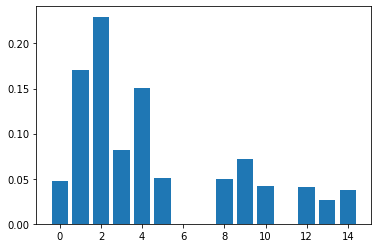

In [ ]:
plt.bar(range(len(model.feature_importances_)),model.feature_importances_)

In [ ]:
from lightgbm import LGBMClassifier
LGB= LGBMClassifier(random_state=1)
LGB.fit(X_train, y_train)

LGBMClassifier(random_state=1)

In [ ]:
y_pred =LGB.predict_proba(X_test)
y_pred[:10]

array([[1.00000000e+000, 0.00000000e+000],
       [9.99998990e-001, 1.01030903e-006],
       [1.00000000e+000, 2.82994650e-030],
       [1.00000000e+000, 7.33590054e-049],
       [9.99994630e-001, 5.36963442e-006],
       [1.15824239e-009, 9.99999999e-001],
       [1.00000000e+000, 6.24697059e-143],
       [1.00000000e+000, 7.99709263e-127],
       [1.00000000e+000, 0.00000000e+000],
       [9.99938530e-001, 6.14704228e-005]])

In [ ]:
roc = metrics.roc_auc_score(y_test, y_pred[:,1])
print("AUC: %.2F%%" % (roc *100.0))

AUC: 80.28%


In [ ]:
LGB = LGBMClassifier(learning_rate= 0.2,max_depth=2, n_estimators=200,subsample=0.6,random_state=1)
LGB.fit(X_train, y_train)

LGBMClassifier(learning_rate=0.2, max_depth=2, n_estimators=200, random_state=1,
               subsample=0.6)

In [ ]:
y_pred = LGB.predict_proba(X_test)
roc = metrics.roc_auc_score(y_test, y_pred[:,1])
print("AUC: %.2F%%" % (roc *100.0))

AUC: 73.16%


In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 12.3 MB/s eta 0:00:00


In [ ]:
from catboost import CatBoostClassifier
Cat = CatBoostClassifier(random_state=1)
Cat.fit(X_train, y_train)

Learning rate set to 0.06692
0:	learn: 0.5107569	total: 61ms	remaining: 1m
1:	learn: 0.3708133	total: 73.1ms	remaining: 36.5s
2:	learn: 0.2729211	total: 86.1ms	remaining: 28.6s
3:	learn: 0.2003287	total: 98.6ms	remaining: 24.5s
4:	learn: 0.1525553	total: 113ms	remaining: 22.4s
5:	learn: 0.1183012	total: 127ms	remaining: 21s
6:	learn: 0.0926958	total: 141ms	remaining: 20s
7:	learn: 0.0741227	total: 154ms	remaining: 19.1s
8:	learn: 0.0608923	total: 167ms	remaining: 18.4s
9:	learn: 0.0465873	total: 181ms	remaining: 18s
10:	learn: 0.0387760	total: 198ms	remaining: 17.8s
11:	learn: 0.0329883	total: 211ms	remaining: 17.4s
12:	learn: 0.0289558	total: 224ms	remaining: 17s
13:	learn: 0.0251152	total: 237ms	remaining: 16.7s
14:	learn: 0.0217928	total: 250ms	remaining: 16.4s
15:	learn: 0.0196789	total: 262ms	remaining: 16.1s
16:	learn: 0.0177198	total: 276ms	remaining: 15.9s
17:	learn: 0.0161779	total: 289ms	remaining: 15.7s
18:	learn: 0.0150968	total: 301ms	remaining: 15.6s
19:	learn: 0.0141161	

In [ ]:
Cat = CatBoostClassifier(learning_rate=0.2, max_depth=2, n_estimators=200, subsample=0.6, random_state=1)
Cat.fit(X_train,y_train)

0:	learn: 0.2613976	total: 38ms	remaining: 7.56s
1:	learn: 0.1107186	total: 64.1ms	remaining: 6.34s
2:	learn: 0.0567430	total: 87.5ms	remaining: 5.75s
3:	learn: 0.0348212	total: 121ms	remaining: 5.94s
4:	learn: 0.0248359	total: 159ms	remaining: 6.19s
5:	learn: 0.0195197	total: 195ms	remaining: 6.31s
6:	learn: 0.0164362	total: 229ms	remaining: 6.32s
7:	learn: 0.0144481	total: 262ms	remaining: 6.28s
8:	learn: 0.0137617	total: 298ms	remaining: 6.33s
9:	learn: 0.0130998	total: 322ms	remaining: 6.11s
10:	learn: 0.0127017	total: 348ms	remaining: 5.98s
11:	learn: 0.0125860	total: 380ms	remaining: 5.95s
12:	learn: 0.0123629	total: 409ms	remaining: 5.89s
13:	learn: 0.0122493	total: 450ms	remaining: 5.98s
14:	learn: 0.0119358	total: 479ms	remaining: 5.91s
15:	learn: 0.0118869	total: 527ms	remaining: 6.06s
16:	learn: 0.0116832	total: 575ms	remaining: 6.19s
17:	learn: 0.0115108	total: 613ms	remaining: 6.2s
18:	learn: 0.0114066	total: 659ms	remaining: 6.28s
19:	learn: 0.0112929	total: 680ms	remaini

In [ ]:
y_pred = Cat.predict_proba(X_test)
roc =  metrics.roc_auc_score(y_test, y_pred[:,1])
print("AUC: %.2F%%" % (roc *100.0))

AUC: 96.31%
